<a href="https://colab.research.google.com/github/neohaky/deeplearning/blob/main/tugas2_trainingdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Cell 1: Import Necessary Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Cell 2: Mount Google Drive and check dataset structure
from google.colab import drive
drive.mount('/content/drive')

# Define dataset path (change this to your folder path)
dataset_path = '/content/drive/MyDrive/Alat_dapur'  # Change to your folder name

# Verify folder structure
classes = os.listdir(dataset_path)
print("Classes found:", classes)

# Count number of images per class
for cls in classes:
    cls_path = os.path.join(dataset_path, cls)
    print(f"Number of {cls} images: {len(os.listdir(cls_path))}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classes found: ['Spatula ', 'Piring ', 'pisau dapur', 'penjepit makanan']
Number of Spatula  images: 328
Number of Piring  images: 395
Number of pisau dapur images: 300
Number of penjepit makanan images: 340


In [4]:
# Cell 3: Create dataframe with image paths and labels
# Create a dataframe with image paths and corresponding labels
image_paths = []
labels = []

for label in classes:
    class_path = os.path.join(dataset_path, label)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image_paths.append(image_path)
        labels.append(label)

# Create dataframe
df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Shuffle the dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display first few rows
print(df.head())

# Check class distribution
print("\nClass distribution:")
print(df['label'].value_counts())

                                          image_path        label
0  /content/drive/MyDrive/Alat_dapur/Piring /ff66...      Piring 
1  /content/drive/MyDrive/Alat_dapur/pisau dapur/...  pisau dapur
2  /content/drive/MyDrive/Alat_dapur/pisau dapur/...  pisau dapur
3  /content/drive/MyDrive/Alat_dapur/Piring /4a9b...      Piring 
4  /content/drive/MyDrive/Alat_dapur/Piring /d754...      Piring 

Class distribution:
label
Piring              395
penjepit makanan    340
Spatula             328
pisau dapur         300
Name: count, dtype: int64


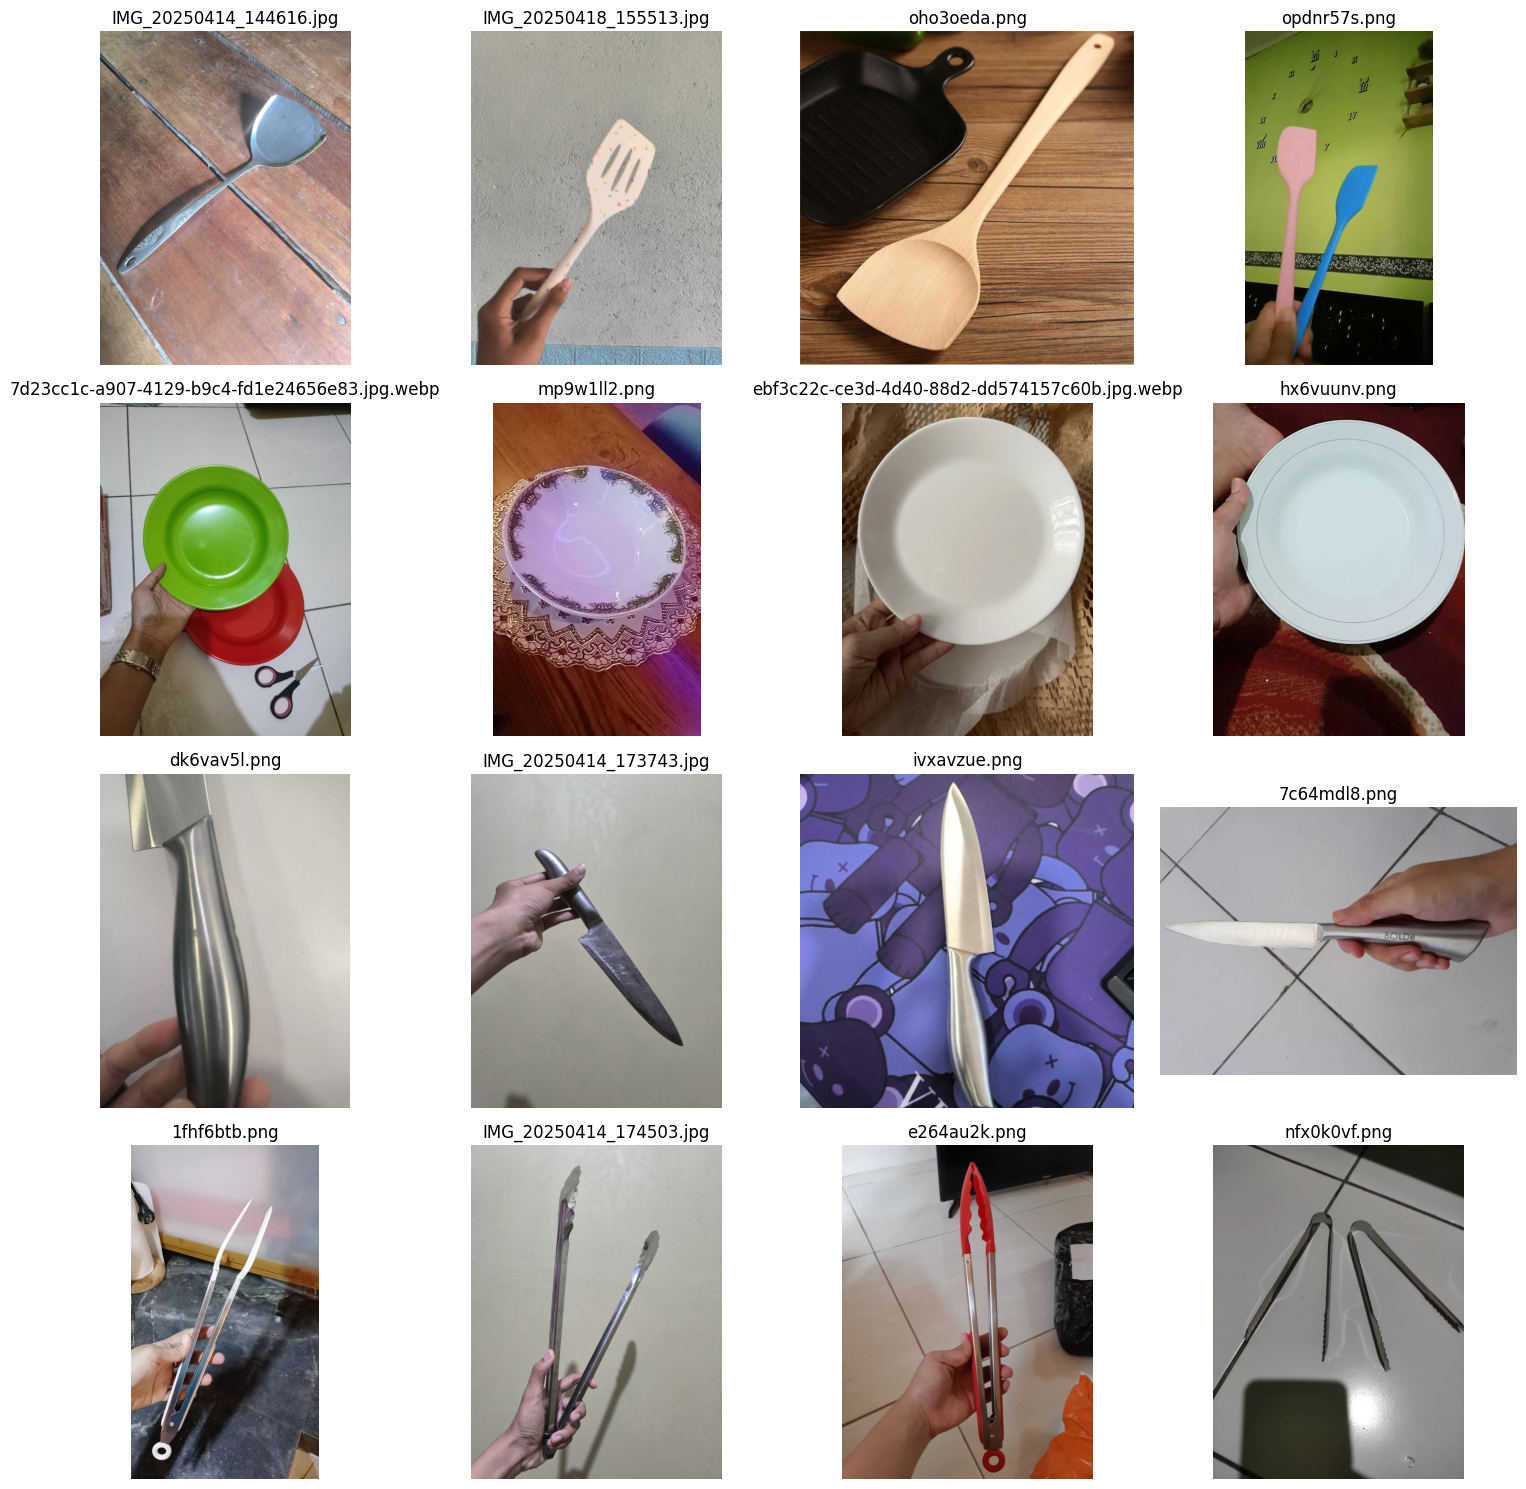

In [5]:
# Cell 4: Visualize images from the dataset
# Function to display images
def plot_images(images, titles, rows=1, cols=4, figsize=(15, 5)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.ravel() if rows > 1 else axes

    for idx, (image, title) in enumerate(zip(images, titles)):
        img = Image.open(image)
        axes[idx].imshow(img)
        axes[idx].set_title(title)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Sample 4 images from each class
samples = []
for cls in classes:
    cls_samples = df[df['label'] == cls].sample(4, random_state=42)['image_path'].values
    samples.extend(cls_samples)

plot_images(samples, [os.path.basename(img) for img in samples], rows=4, cols=4, figsize=(15, 15))

In [6]:
# Cell 5: Define transforms and split dataset
# Define image transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Split dataset into train (70%), validation (15%), and test (15%)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

# Check class distribution in splits
print("\nTrain class distribution:")
print(train_df['label'].value_counts())
print("\nValidation class distribution:")
print(val_df['label'].value_counts())
print("\nTest class distribution:")
print(test_df['label'].value_counts())

Train size: 954
Validation size: 204
Test size: 205

Train class distribution:
label
Piring              276
penjepit makanan    238
Spatula             230
pisau dapur         210
Name: count, dtype: int64

Validation class distribution:
label
Piring              59
penjepit makanan    51
Spatula             49
pisau dapur         45
Name: count, dtype: int64

Test class distribution:
label
Piring              60
penjepit makanan    51
Spatula             49
pisau dapur         45
Name: count, dtype: int64


In [7]:
# Cell 6: Create custom dataset class
class FlowerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.label_to_idx = {label: idx for idx, label in enumerate(classes)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label_idx = self.label_to_idx[label]

        return image, label_idx

# Create datasets
train_dataset = FlowerDataset(train_df, transform=train_transform)
val_dataset = FlowerDataset(val_df, transform=val_test_transform)
test_dataset = FlowerDataset(test_df, transform=val_test_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Check one batch
images, labels = next(iter(train_loader))
print(f"Batch image shape: {images.shape}")
print(f"Batch labels: {labels}")

Batch image shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([2, 0, 3, 1, 1, 0, 0, 1, 2, 1, 1, 3, 3, 0, 1, 3, 0, 2, 3, 1, 1, 0, 3, 3,
        3, 0, 1, 3, 1, 1, 1, 3])


In [9]:
# Cell 7: Define the model (using ResNet18 pretrained) with tabular output
from torchsummary import summary

class FlowerClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(FlowerClassifier, self).__init__()
        # Use pretrained ResNet18
        self.model = models.resnet18(pretrained=True)

        # Freeze all layers except the final layer
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace the final fully connected layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

model = FlowerClassifier(num_classes=len(classes)).to(device)

# Print model summary in tabular form
print("\nModel Architecture Summary:")
summary(model, input_size=(3, 224, 224), device=device.type)

# Additional detailed print of the model
print("\nDetailed Model Structure:")
print(model)


Model Architecture Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
          

In [11]:
# Cell 8: Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

# Function to compute accuracy
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    model.eval()
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(device)
            targets = targets.to(device)
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

# Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    best_val_acc = 0.0
    best_model_weights = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct_train / total_train
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = 100 * correct_val / total_val
        val_loss_history.append(val_epoch_loss)
        val_acc_history.append(val_epoch_acc)

        scheduler.step(val_epoch_loss)

        # Save best model
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_model_weights = model.state_dict()

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%')
        print(f'Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.2f}%')
        print('-' * 20)

    # Load best model weights
    model.load_state_dict(best_model_weights)
    print(f'Best Val Accuracy: {best_val_acc:.2f}%')

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
# Cell 9: Train the model
num_epochs = 50
trained_model, train_loss, val_loss, train_acc, val_acc = train_model(
    model, criterion, optimizer, scheduler, num_epochs=num_epochs
)

# Save the trained model
torch.save(trained_model.state_dict(), 'flower_classifier_resnet18.pth')

Epoch 1/50
Train Loss: 1.1229, Acc: 51.15%
Val Loss: 0.5889, Acc: 82.84%
--------------------
Epoch 2/50
Train Loss: 0.8041, Acc: 69.18%
Val Loss: 0.5249, Acc: 78.92%
--------------------
Epoch 3/50
Train Loss: 0.7226, Acc: 71.80%
Val Loss: 0.4208, Acc: 82.84%
--------------------
Epoch 4/50
Train Loss: 0.6855, Acc: 71.91%
Val Loss: 0.4327, Acc: 82.84%
--------------------
Epoch 5/50
Train Loss: 0.6295, Acc: 77.78%
Val Loss: 0.3776, Acc: 85.29%
--------------------
Epoch 6/50
Train Loss: 0.6391, Acc: 74.21%
Val Loss: 0.4843, Acc: 80.88%
--------------------
Epoch 7/50
Train Loss: 0.6672, Acc: 73.90%
Val Loss: 0.4627, Acc: 82.35%
--------------------
Epoch 8/50
Train Loss: 0.6034, Acc: 77.99%
Val Loss: 0.5434, Acc: 80.39%
--------------------
Epoch 9/50
Train Loss: 0.6032, Acc: 76.00%
Val Loss: 0.4688, Acc: 81.37%
--------------------
Epoch 10/50
Train Loss: 0.5823, Acc: 76.62%
Val Loss: 0.4276, Acc: 83.82%
--------------------
Epoch 11/50
Train Loss: 0.5493, Acc: 79.14%
Val Loss: 0.395

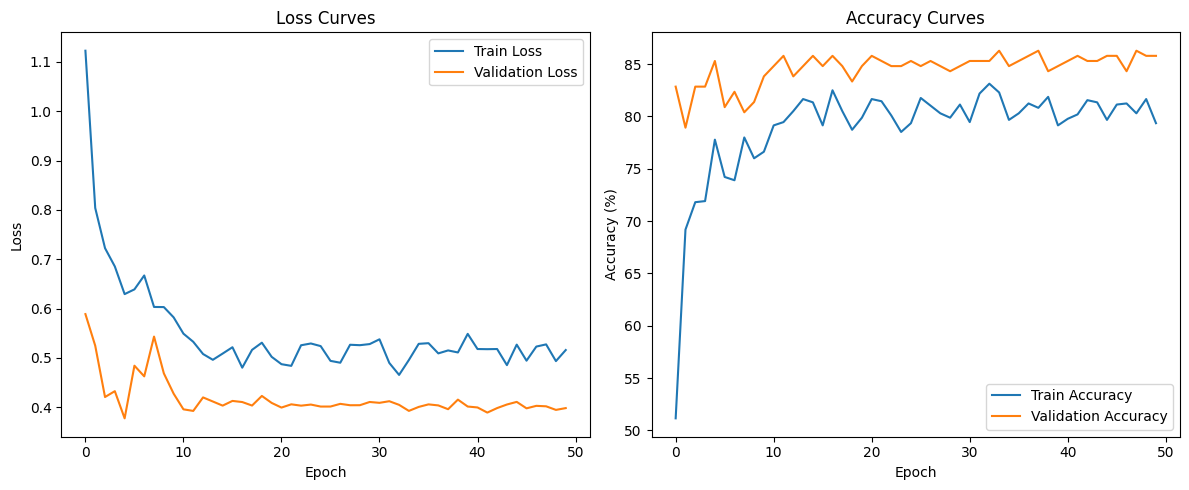

In [13]:
# Cell 10: Plot training and validation loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Cell 11: Evaluate on test set
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = 100 * np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return test_acc

test_accuracy = evaluate_model(trained_model, test_loader, device)

In [ ]:
# Cell 12: Make predictions on test images
def predict_image(model, image_path, transform, classes):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        conf, predicted_idx = torch.max(probabilities, 0)
        predicted_label = classes[predicted_idx.item()]

    return predicted_label, conf.item()

# Test on some sample images
sample_images = test_df.sample(6, random_state=42)['image_path'].values

plt.figure(figsize=(15, 10))
for idx, img_path in enumerate(sample_images):
    plt.subplot(2, 3, idx+1)
    image = Image.open(img_path)
    plt.imshow(image)

    predicted_label, confidence = predict_image(trained_model, img_path, val_test_transform, classes)
    true_label = test_df[test_df['image_path'] == img_path]['label'].values[0]

    title = f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}"
    color = 'green' if predicted_label == true_label else 'red'
    plt.title(title, color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Cell 13: Grad-CAM Visualization
import cv2
from torchvision.models.feature_extraction import create_feature_extractor

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.model.eval()
        self.hook_layers()

    def hook_layers(self):
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        def forward_hook(module, input, output):
            self.activations = output

        # Get the target layer
        target_layer = dict([*self.model.named_modules()])[self.target_layer]
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_full_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class=None):
        # Forward pass
        output = self.model(input_image)

        if target_class is None:
            target_class = torch.argmax(output)

        # Zero gradients
        self.model.zero_grad()

        # Backward pass for the target class
        one_hot = torch.zeros_like(output)
        one_hot[0][target_class] = 1
        output.backward(gradient=one_hot)

        # Get gradients and activations
        gradients = self.gradients.detach().cpu().numpy()[0]
        activations = self.activations.detach().cpu().numpy()[0]

        # Compute weights
        weights = np.mean(gradients, axis=(1, 2))

        # Compute CAM
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        # Apply ReLU and normalize
        cam = np.maximum(cam, 0)
        cam = cam - np.min(cam)
        cam = cam / (np.max(cam) + 1e-10)
        cam = cv2.resize(cam, (input_image.shape[2], input_image.shape[3]))

        return cam

# Initialize Grad-CAM
gradcam = GradCAM(trained_model, 'model.layer4.1')

# Select some images for visualization
viz_images = test_df.sample(3, random_state=42)['image_path'].values

plt.figure(figsize=(15, 10))
for idx, img_path in enumerate(viz_images):
    # Load and transform image
    image = Image.open(img_path).convert('RGB')
    image_tensor = val_test_transform(image).unsqueeze(0).to(device)

    # Get prediction
    with torch.no_grad():
        output = trained_model(image_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        conf, predicted_idx = torch.max(probabilities, 0)
        predicted_label = classes[predicted_idx.item()]

    true_label = test_df[test_df['image_path'] == img_path]['label'].values[0]

    # Generate CAM
    cam = gradcam.generate_cam(image_tensor, predicted_idx)

    # Convert CAM to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Superimpose on original image
    img = np.array(image)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    superimposed_img = heatmap * 0.4 + img * 0.6
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    # Plot
    plt.subplot(3, 3, idx*3 + 1)
    plt.imshow(img)
    plt.title(f"Original\nTrue: {true_label}")
    plt.axis('off')

    plt.subplot(3, 3, idx*3 + 2)
    plt.imshow(heatmap)
    plt.title("Heatmap")
    plt.axis('off')

    plt.subplot(3, 3, idx*3 + 3)
    plt.imshow(superimposed_img)
    plt.title(f"Pred: {predicted_label}\nConf: {conf.item():.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Cell 14: Compute Error Rate Analysis
def analyze_errors(model, test_loader, classes, device, top_k=5):
    model.eval()
    errors = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Get indices of incorrect predictions
            incorrect_mask = (preds != labels)
            incorrect_indices = torch.nonzero(incorrect_mask).squeeze()

            if incorrect_indices.numel() == 0:
                continue

            if incorrect_indices.numel() == 1:
                incorrect_indices = incorrect_indices.unsqueeze(0)

            # Get incorrect samples
            incorrect_inputs = inputs[incorrect_indices]
            incorrect_preds = preds[incorrect_indices]
            incorrect_labels = labels[incorrect_indices]

            # Get probabilities
            probabilities = torch.nn.functional.softmax(outputs[incorrect_indices], dim=1)

            for i in range(len(incorrect_indices)):
                true_label = incorrect_labels[i].item()
                pred_label = incorrect_preds[i].item()
                prob = probabilities[i][pred_label].item()

                # Get top k predictions
                top_probs, top_indices = torch.topk(probabilities[i], k=top_k)
                top_probs = top_probs.cpu().numpy()
                top_indices = top_indices.cpu().numpy()

                errors.append({
                    'image': incorrect_inputs[i].cpu(),
                    'true_label': true_label,
                    'pred_label': pred_label,
                    'confidence': prob,
                    'top_predictions': list(zip(top_indices, top_probs))
                })

    return errors

# Get error cases
errors = analyze_errors(trained_model, test_loader, classes, device)

# Display some error cases
print(f"Total errors: {len(errors)}")
print(f"Error rate: {len(errors)/len(test_df)*100:.2f}%")

if len(errors) > 0:
    plt.figure(figsize=(15, 10))
    for i in range(min(3, len(errors))):
        error = errors[i]
        image = error['image'].permute(1, 2, 0).numpy()
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
        image = np.clip(image, 0, 1)

        plt.subplot(3, 3, i*3 + 1)
        plt.imshow(image)
        plt.title(f"True: {classes[error['true_label']]}")
        plt.axis('off')

        plt.subplot(3, 3, i*3 + 2)
        plt.bar(range(len(classes)), [0]*len(classes), color='lightgray')
        plt.bar(error['pred_label'], 1, color='red')
        plt.xticks(range(len(classes)), classes, rotation=45)
        plt.title(f"Predicted: {classes[error['pred_label']]}\nConf: {error['confidence']:.2f}")

        plt.subplot(3, 3, i*3 + 3)
        top_indices = [x[0] for x in error['top_predictions']]
        top_probs = [x[1] for x in error['top_predictions']]
        plt.bar(range(len(top_indices)), top_probs, color=['red' if i == error['pred_label'] else 'blue' for i in top_indices])
        plt.xticks(range(len(top_indices)), [classes[idx] for idx in top_indices], rotation=45)
        plt.title("Top Predictions")

    plt.tight_layout()
    plt.show()